In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Nicolekara/CarPredict/main/dataset.csv')

df.head()

,manufactor,Year,model,Hand,Gear,capacity_Engine,Engine_type,Prev_ownership,Curr_ownership,Area,City,Price,Pic_num,Cre_date,Repub_date,Description,Color,Km,Test,Supply_score
0,יונדאי,2015,i35,2,אוטומטית,1600,בנזין,פרטית,פרטית,רעננה - כפר סבא,רעננה,51000.0,2.0,11/07/2023,11/07/2023,['רכב שמור בקנאות\nמוכרת עקב קבלת רכב חברה'],כחול כהה מטאלי,144000,NaN,NaN
1,ניסאן,2018,ניסאן מיקרה,1,אוטומטית,1200,בנזין,פרטית,פרטית,מושבים בשרון,אבן יהודה,49000.0,0.0,06/04/2022,22/05/2022,['שמורה כל התוספות'],כחול בהיר,69000,NaN,NaN
2,סוזוקי,2010,סוזוקי סוויפט,1,אוטומטית,1450,בנזין,NaN,NaN,רמת,רמת,22500.0,1.0,29/10/2022,29/10/2022,['רכב במצב מתוחזק ברמה גבוהה טסט עד אפריל 2023'],None,145000,NaN,NaN
3,טויוטה,2016,אוריס,1,טיפטרוניק,1600,בנזין,פרטית,פרטית,נס ציונה - רחובות,רחובות,63000.0,5.0,16/05/2024,16/05/2024,['אוטו במצב חדש!! שמור בקנאות!! נהג יחיד מטופל...,אפור מטאלי,27300,NaN,NaN
4,קיה,2012,פיקנטו,1,אוטומטית,1248,בנזין,NaN,NaN,"ראשל""צ והסביבה",ראשון לציון,37000.0,1.0,13/06/2022,13/06/2022,['שמור'],NaN,70000,NaN,4.0


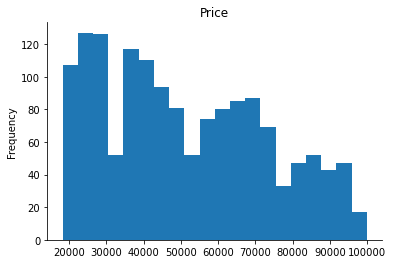

In [3]:
from matplotlib import pyplot as plt
df['Price'].plot(kind='hist', bins=20, title='Price')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   manufactor       1500 non-null   object 
 1   Year             1500 non-null   int64  
 2   model            1500 non-null   object 
 3   Hand             1500 non-null   int64  
 4   Gear             1499 non-null   object 
 5   capacity_Engine  1474 non-null   object 
 6   Engine_type      1495 non-null   object 
 7   Prev_ownership   774 non-null    object 
 8   Curr_ownership   774 non-null    object 
 9   Area             1361 non-null   object 
 10  City             1500 non-null   object 
 11  Price            1500 non-null   float64
 12  Pic_num          1476 non-null   float64
 13  Cre_date         1500 non-null   object 
 14  Repub_date       1500 non-null   object 
 15  Description      1500 non-null   object 
 16  Color            787 non-null    object 
 17  Km            

In [5]:
# פונקציה שתבצע את האיחוד בין העמודות
def combine_ownership(row):
# רשימת ערכים שלא פרטי
  non_private_values = ['השכרה', 'חברה', 'ליסינג', 'מונית', 'ממשלתי']

# בדיקה אם בעמודה Prev_ownership הערך הוא לא פרטי
  if row['Prev_ownership'] in non_private_values:
        return False

# בדיקה אם בעמודה Curr_ownership הערך הוא לא פרטי
  if row['Curr_ownership'] in non_private_values:
        return False

# אחרת, הערך הוא פרטי
  return True

# פונקציה להמרת ערכי Gear לערכים בינאריים
def convert_gear(gear):
    non_manual_values = df.Gear.unique().tolist()
    non_manual_values.remove('ידנית')

    manual_values = ['ידנית']

    if gear in non_manual_values:
        return False
    else:
        return True
# פונקציה להסרת שם היצרן מהמודל
def remove_manufactor_from_model(row):
    manufactor = str(row['manufactor']).strip()
    model = str(row['model']).strip()

    if manufactor in model:
# מחיקת שם היצרן מהמודל והסרת רווחים מיותרים
        return model.replace(manufactor, '').strip()
    else:
        return model

def prepare_data(df):
    df = df.drop_duplicates().reset_index(drop=True)
# הסבת כל הערכים למחרוזות והסרת פסיקים
    df['Km'] = df['Km'].astype(str).str.replace(',', '')
    df['capacity_Engine'] = df["capacity_Engine"].astype(str).str.replace(',', '')

# המרה לערכים מספריים (אם יש ערכים שאינם מספריים הם יהפכו ל-NaN)
    df['Km'] = pd.to_numeric(df['Km'], errors='coerce')
    df["capacity_Engine"] = pd.to_numeric(df['capacity_Engine'], errors='coerce')

# תנאים לשינוי ערכי העמודה
    df.loc[(df['Km'] > 100) & (df['Km'] < 1000), 'Km'] *= 1000
    df.loc[df['Km'] > 1000000, 'Km'] /= 10

# מילוי ערכים מתחת ל-100 בממוצע הקבוצתי לפי עמודת השנה עם transform
    df['Km'] = df.groupby('Year')['Km'].transform(lambda x: x.where(x >= 100, x.mean()))


# הוספת העמודה המאוחדת ל-DataFrame
    df['IsPrivate'] = df.apply(combine_ownership, axis=1)
    df = df.drop(columns=['Prev_ownership', 'Curr_ownership'])

# יצירת מילון להחלפת הערכים בעמודה Engine_type
 # לטיפול בערכים ריקים (מחרוזות ריקות
# לטיפול בערכים ריקים
    engine_type_mapping = {'דיזל': 'דיזל','טורבו דיזל': 'דיזל', 'היבריד': 'היברידי', 'היברידי': 'היברידי', None: 'דיזל', '': 'דיזל'}

# החלפת הערכים בעמודה
    df['Engine_type'] = df['Engine_type'].replace(engine_type_mapping)
# המרת הערכים ישירות בעמודת Gear
    df['IsManual'] = df['Gear'].apply(convert_gear)

    df.manufactor = df.manufactor.replace('Lexsus' , 'לקסוס')
# החלפת הערכים בעמודת model
    df['model'] = df.apply(remove_manufactor_from_model, axis=1)
    return df


In [6]:
df = prepare_data(df)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd; 

# הגדרת רשימות המשתנים
numeric_col = ['Year', 'Hand', 'Km']
cat_col = ["Engine_type",  'model']
binary_col = ['IsPrivate', 'IsManual']
y_col = 'Price'
# הגדרת טרנספורמציות עבור כל סוג משתנה
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown ='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_col),('cat', categorical_transformer, cat_col),('bin', 'passthrough', binary_col)])

# יצירת ה-Pipeline המלא
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# החלת ה-Pipeline על הנתונים
x = df.drop(columns=[y_col])
x = pipeline.fit_transform(x)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df, df[y_col], test_size=0.2, random_state=22)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# החלת ה-Pipeline על נתוני האימון בלבד
X_train_transformed = pipeline.fit_transform(X_train)

# החלת ה-Pipeline על נתוני הבדיקה (ללא התאמה)
X_test_transformed = pipeline.transform(X_test)

In [9]:

# הגדרת רשת של היפר-פרמטרים
param_grid = {'alpha': [0.001, 0.00005, 0.1, 1],'l1_ratio': [ 0.5,0.6,0.7]}

# יצירת מודל אלסטי נט
elastic_net = ElasticNet()

# חיפוש גריד עבור ההיפר-פרמטרים הטובים ביותר באמצעות אימות צולב
grid_search = GridSearchCV(elastic_net, param_grid, cv=10)
grid_search.fit(x, df[y_col])

# בחירת המודל הטוב ביותר
best_model = grid_search.best_estimator_

# חיזוי על נתוני הבדיקה
y_pred = best_model.predict(x)

# הערכת המודל
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
print("Best model:", best_model)


print("Mean Squared Error:", mean_squared_error(df[y_col], y_pred))

C:\Users\Nicol\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45866422769.18173, tolerance: 60918826.144114114
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Nicol\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49985739396.53232, tolerance: 61401271.27937577
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Nicol\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49187606473.76247, tolerance: 61584235.20709345
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\Nicol\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:

Best parameters: {'alpha': 0.001, 'l1_ratio': 0.5}
Best score: 0.6007588533410717
Best model: ElasticNet(alpha=0.001)
Mean Squared Error: 99487107.8857079


In [10]:
# חיזוי על נתוני הבדיקה
#y_pred = best_model.predict(X_test_transformed)

# חישוב מדדי הערכה
mse = mean_squared_error(df[y_col], y_pred)
mae = mean_absolute_error(df[y_col], y_pred)
r2 = r2_score(df[y_col], y_pred)
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:",  r2)

Root Mean Squared Error: 9974.32242739866
Mean Squared Error: 99487107.8857079
Mean Absolute Error: 7289.99171475062
R-squared: 0.7984609914279521


In [14]:
# חילוץ ה- OneHotEncoder מה- ColumnTransformer
onehot_encoder = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']

# חילוץ שמות הפיצ'רים
try:
    feature_names = onehot_encoder.get_feature_names_out()
except AttributeError:
    feature_names = onehot_encoder.get_feature_names()

# חיבור שמות הפיצ'רים המקוריים לשמות החדשים
all_feature_names = list(numeric_col) + list(feature_names) + binary_col


In [13]:
print(len(all_feature_names), len(coefficients),len()

264 285


In [30]:
if len(all_feature_names) != len(coefficients):
# If all_feature_names is longer, trim it
    if len(all_feature_names) > len(coefficients):
        print("Trimming all_feature_names to match coefficients.")
        all_feature_names = all_feature_names[:len(coefficients)]
# If coefficients is longer, trim it
    else:
        print("Trimming coefficients to match all_feature_names.")
        coefficients = coefficients[:len(all_feature_names)]
    
print(len(all_feature_names), len(coefficients))

# יצירת DataFrame להצגה טובה יותר
coef_df = pd.DataFrame({'feature': all_feature_names, 'coefficient': coefficients})
print(coef_df)

264 264
       feature   coefficient
0         Year  13420.899032
1         Hand   -822.573471
2           Km  -4826.997940
3     x0_בנזין   -815.750304
4        x0_גז  -1188.644478
..         ...           ...
259     x1_ריו  -9110.737913
260  x1_שירוקו -20075.628330
261   x1_שרמנט   1065.063739
262  IsPrivate -17666.270294
263   IsManual -13320.225487

[264 rows x 2 columns]
